<a href="https://colab.research.google.com/github/AdamChoong0095/NUS-Stock-Data/blob/Adam/Stock_price_prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Setting up the data**

In [82]:
import math
from sklearn import linear_model
from datetime import datetime
import matplotlib.pyplot as plt
import pandas as pd

import numpy as np

sp500=pd.read_csv('spy.us.txt')
Timestamp = []
quarter = []
first = datetime.strptime(sp500['Date'][0], '%Y-%m-%d').date()
for index, row in sp500.iterrows():
  date = row['Date']
  t = datetime.strptime(date, '%Y-%m-%d').date()

  Timestamp.append((t-first).days)
  quarter.append(math.ceil(datetime.strptime(date, '%Y-%m-%d').month/3.))

sp500['Constant'] = np.ones(len(sp500))
sp500['Timestamp'] = Timestamp
sp500['Quarter'] = quarter



sp500['nextOpen'] = sp500['Open'].shift(-1)
sp500['nextTimestamp'] = sp500['Timestamp'].shift(-1)
sp500['nextQuarter'] = sp500['Quarter'].shift(-1)

sp500 = pd.get_dummies(sp500,columns=['nextQuarter'], dtype=int)

sp500['t'] = sp500['nextTimestamp']-sp500['Timestamp']

sp500['logOpen'] = np.log(sp500['Open'])
sp500['logHigh'] = np.log(sp500['High'])
sp500['logLow'] = np.log(sp500['Low'])
sp500['logClose'] = np.log(sp500['Close'])
sp500['nextlogOpen'] = np.log(sp500['nextOpen'])


sp500 = sp500.dropna()
sp500 = sp500.drop(columns=['OpenInt'])
train_size = int(len(sp500) * 0.8)


print(sp500)


            Date    Open    High     Low   Close    Volume  Constant  \
0     2005-02-25  104.77  106.00  104.68  105.79  70221808       1.0   
1     2005-02-28  105.55  105.68  104.56  105.08  79695344       1.0   
2     2005-03-01  105.22  105.87  105.22  105.62  54607412       1.0   
3     2005-03-02  105.21  106.22  105.10  105.57  73733090       1.0   
4     2005-03-03  105.99  106.20  105.15  105.61  71286823       1.0   
...          ...     ...     ...     ...     ...       ...       ...   
3195  2017-11-03  257.77  258.50  257.30  258.45  59578151       1.0   
3196  2017-11-06  258.30  259.00  258.22  258.85  49529148       1.0   
3197  2017-11-07  258.97  259.35  258.11  258.67  57218448       1.0   
3198  2017-11-08  258.47  259.22  258.15  259.11  50277699       1.0   
3199  2017-11-09  257.73  258.39  256.36  258.17  94537282       1.0   

      Timestamp  Quarter  nextOpen  ...  nextQuarter_1.0  nextQuarter_2.0  \
0             0        1    105.55  ...                1  

**Model Training**

0.5872578891715815
['Open', 'High', 'Close', 'nextQuarter_2.0']


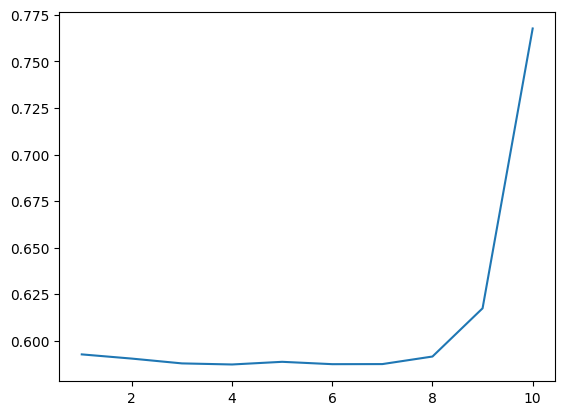

In [114]:
log = False
rolling = True
k = 4
foldsize = int(train_size/k)

if log:
    X_labels = ['logOpen', 'logHigh', 'logLow', 'logClose', 'Volume', 'nextTimestamp', 't', 'nextQuarter_1.0', 'nextQuarter_2.0', 'nextQuarter_3.0']
    y_labels = ['nextlogOpen']
else:
    X_labels = ['Open', 'High', 'Low', 'Close', 'Volume', 'nextTimestamp', 't', 'nextQuarter_1.0', 'nextQuarter_2.0', 'nextQuarter_3.0']
    y_labels = ['nextOpen']

loss = []

def lossfunc(labels):
    regr = linear_model.LinearRegression()
    averageloss = 0

    for i in range(k):
        if rolling:
            if i == k-1: continue
            X = sp500[i*foldsize:(i+1)*foldsize][labels]
            Y = sp500[i*foldsize:(i+1)*foldsize][y_labels]
        else:
            X = sp500[i*foldsize:int((i+0.8)*foldsize)][labels]
            Y = sp500[i*foldsize:int((i+0.8)*foldsize)][y_labels]
        regr.fit(X, Y)


        predicted = regr.predict(sp500[labels]).flatten()

        if log:
            abserror = abs(np.exp(predicted)-sp500['nextOpen'])
        else:    
            abserror = abs(predicted-sp500['nextOpen']) 
        if rolling:
            averageloss += abserror[(i+1)*foldsize:min((i+2)*foldsize,train_size)].mean()/(k-1)
        else:
            averageloss += abserror[int((i+0.8)*foldsize):min((i+1)*foldsize,train_size)].mean()/(k)
    

    return averageloss
    
goals = []
inputs = []

for i in range(len(X_labels)-1):
    
    goal = lossfunc(X_labels)
    inputs.append(X_labels.copy())
    goals.append(goal)


    tests = []
    for j in range(len(X_labels)):
        newlabels = [x for x in X_labels if x != X_labels[j]]
        loss = lossfunc(newlabels)
        tests.append(loss)

    argmin = min(enumerate(tests), key=lambda x: x[1])[0]
    del X_labels[argmin]


goals.append(lossfunc(X_labels))
inputs.append(X_labels.copy())

print(min(goals))
print(inputs[np.argmin(goals)])

plt.plot(list(range(len(goals),0,-1)), goals)  # Plot the chart
plt.show()  # display


**Model evalutaion**

constant: -0.08848288782941438
coefficients: [-0.05904633  0.08906469  0.97040554  0.00586111]
MAE: 0.6805225036653942
MSE: 1.1153362148267614


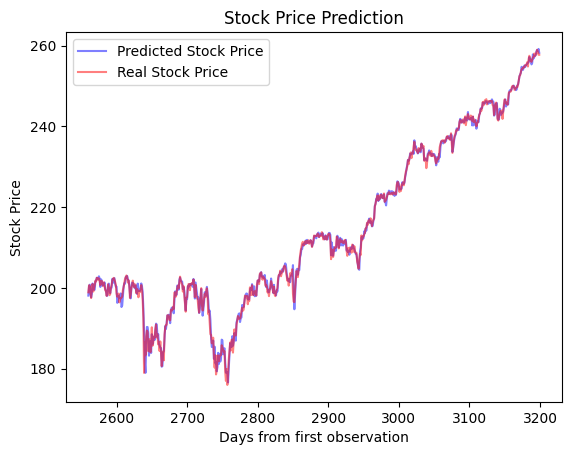

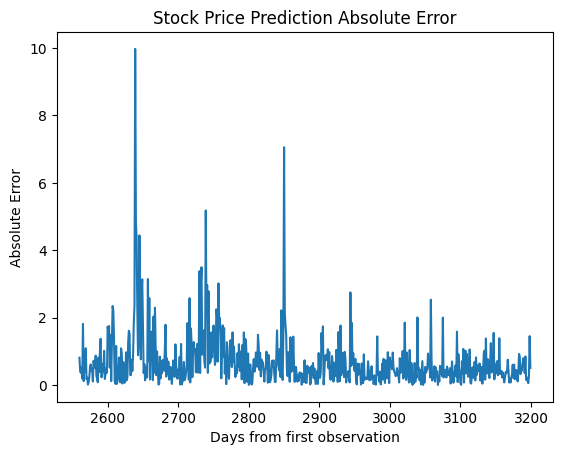

In [115]:
log = False
if log:
    X_labels = ['logHigh', 'logClose']
    y = sp500[:train_size]['nextlogOpen']
else:
    X_labels = ['Open', 'High', 'Close', 'nextQuarter_2.0']
    y = sp500[:train_size]['nextOpen']

regr = linear_model.LinearRegression()
X = sp500[:train_size][X_labels]
regr.fit(X, y)
print(f"constant: {regr.intercept_}")
print(f"coefficients: {regr.coef_}")

if log: 
    sp500['predicted'] = np.exp(regr.predict(sp500[X_labels]))
else:
    sp500['predicted'] = regr.predict(sp500[X_labels])



sp500['error'] = sp500['predicted']-sp500['nextOpen']
sp500['abserror'] = abs(sp500['error'])
sp500['squarederror'] = sp500['abserror'] **2

print(f"MAE: {sp500['abserror'][train_size:].mean()}")
print(f"MSE: {sp500['squarederror'][train_size:].mean()}")

plt.plot(sp500[train_size:]['predicted'], alpha=0.5, color='blue', label='Predicted Stock Price')
plt.plot(sp500[train_size:]['nextOpen'], alpha=0.5, color='red', label='Real Stock Price')
plt.title('Stock Price Prediction')
plt.xlabel('Days from first observation')
plt.ylabel('Stock Price')
plt.legend()
plt.show()
plt.plot(sp500[train_size:]['abserror'])
plt.title('Stock Price Prediction Absolute Error')
plt.xlabel('Days from first observation')
plt.ylabel('Absolute Error')
plt.show()


**Comparisson**

MAE: 0.6835468749999998
MSE: 1.115046093750001


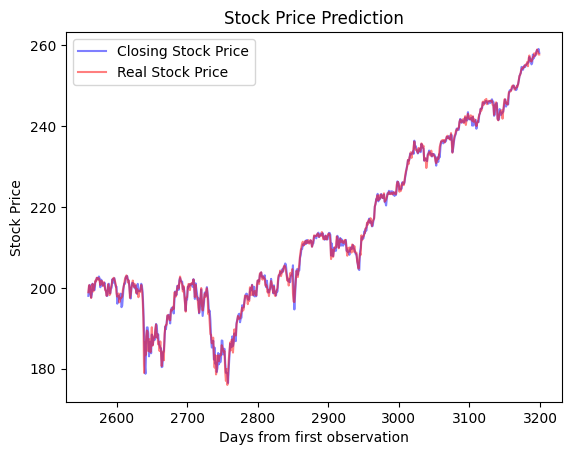

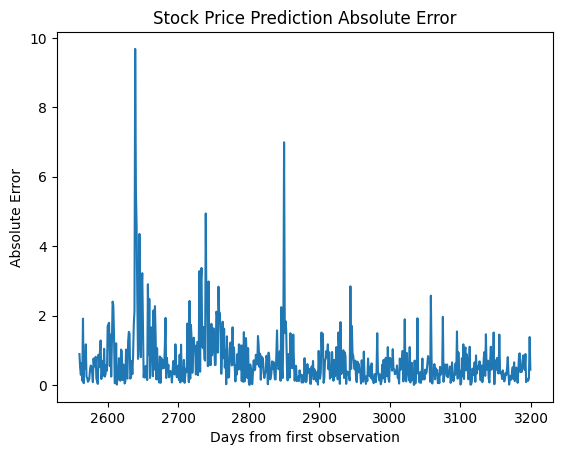

In [85]:
sp500['error'] = sp500['Close']-sp500['nextOpen']
sp500['abserror'] = abs(sp500['error'])
sp500['squarederror'] = sp500['abserror'] **2

print(f"MAE: {sp500['abserror'][train_size:].mean()}")
print(f"MSE: {sp500['squarederror'][train_size:].mean()}")

plt.plot(sp500[train_size:]['Close'], alpha=0.5, color='blue', label='Closing Stock Price')
plt.plot(sp500[train_size:]['nextOpen'], alpha=0.5, color='red', label='Real Stock Price')
plt.title('Stock Price Prediction')
plt.xlabel('Days from first observation')
plt.ylabel('Stock Price')
plt.legend()
plt.show()
plt.plot(sp500[train_size:]['abserror'])
plt.title('Stock Price Prediction Absolute Error')
plt.xlabel('Days from first observation')
plt.ylabel('Absolute Error')
plt.show()